In [1]:
# Why care about "tokenization :("?
# - actually a lot of later problems in LLMs come from it
# - a lot of issues that might seem like they're do to the model architecture are actually due to tokenization

# Tokenization :(

Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

- Why can't LLM spell words? **Tokenization**.
- Why can't LLM do super simple string processing tasks like reversing a string? **Tokenization**.
- Why is LLM worse at non-English languages (e.g. Japanese)? **Tokenization**.
- Why is LLM bad at simple arithmetic? **Tokenization**.
- Why did GPT-2 have more than necessary trouble coding in Python? **Tokenization**.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? **Tokenization**.
- What is this weird warning I get about a "trailing whitespace"? **Tokenization**.
- Why the LLM break if I ask it about "SolidGoldMagikarp"? **Tokenization**.
- Why should I prefer to use YAML over JSON with LLMs? **Tokenization**.
- Why is LLM not actually end-to-end language modeling? **Tokenization**.
- What is the real root of suffering? **Tokenization**.

In [117]:
%load_ext autoreload
%autoreload 2

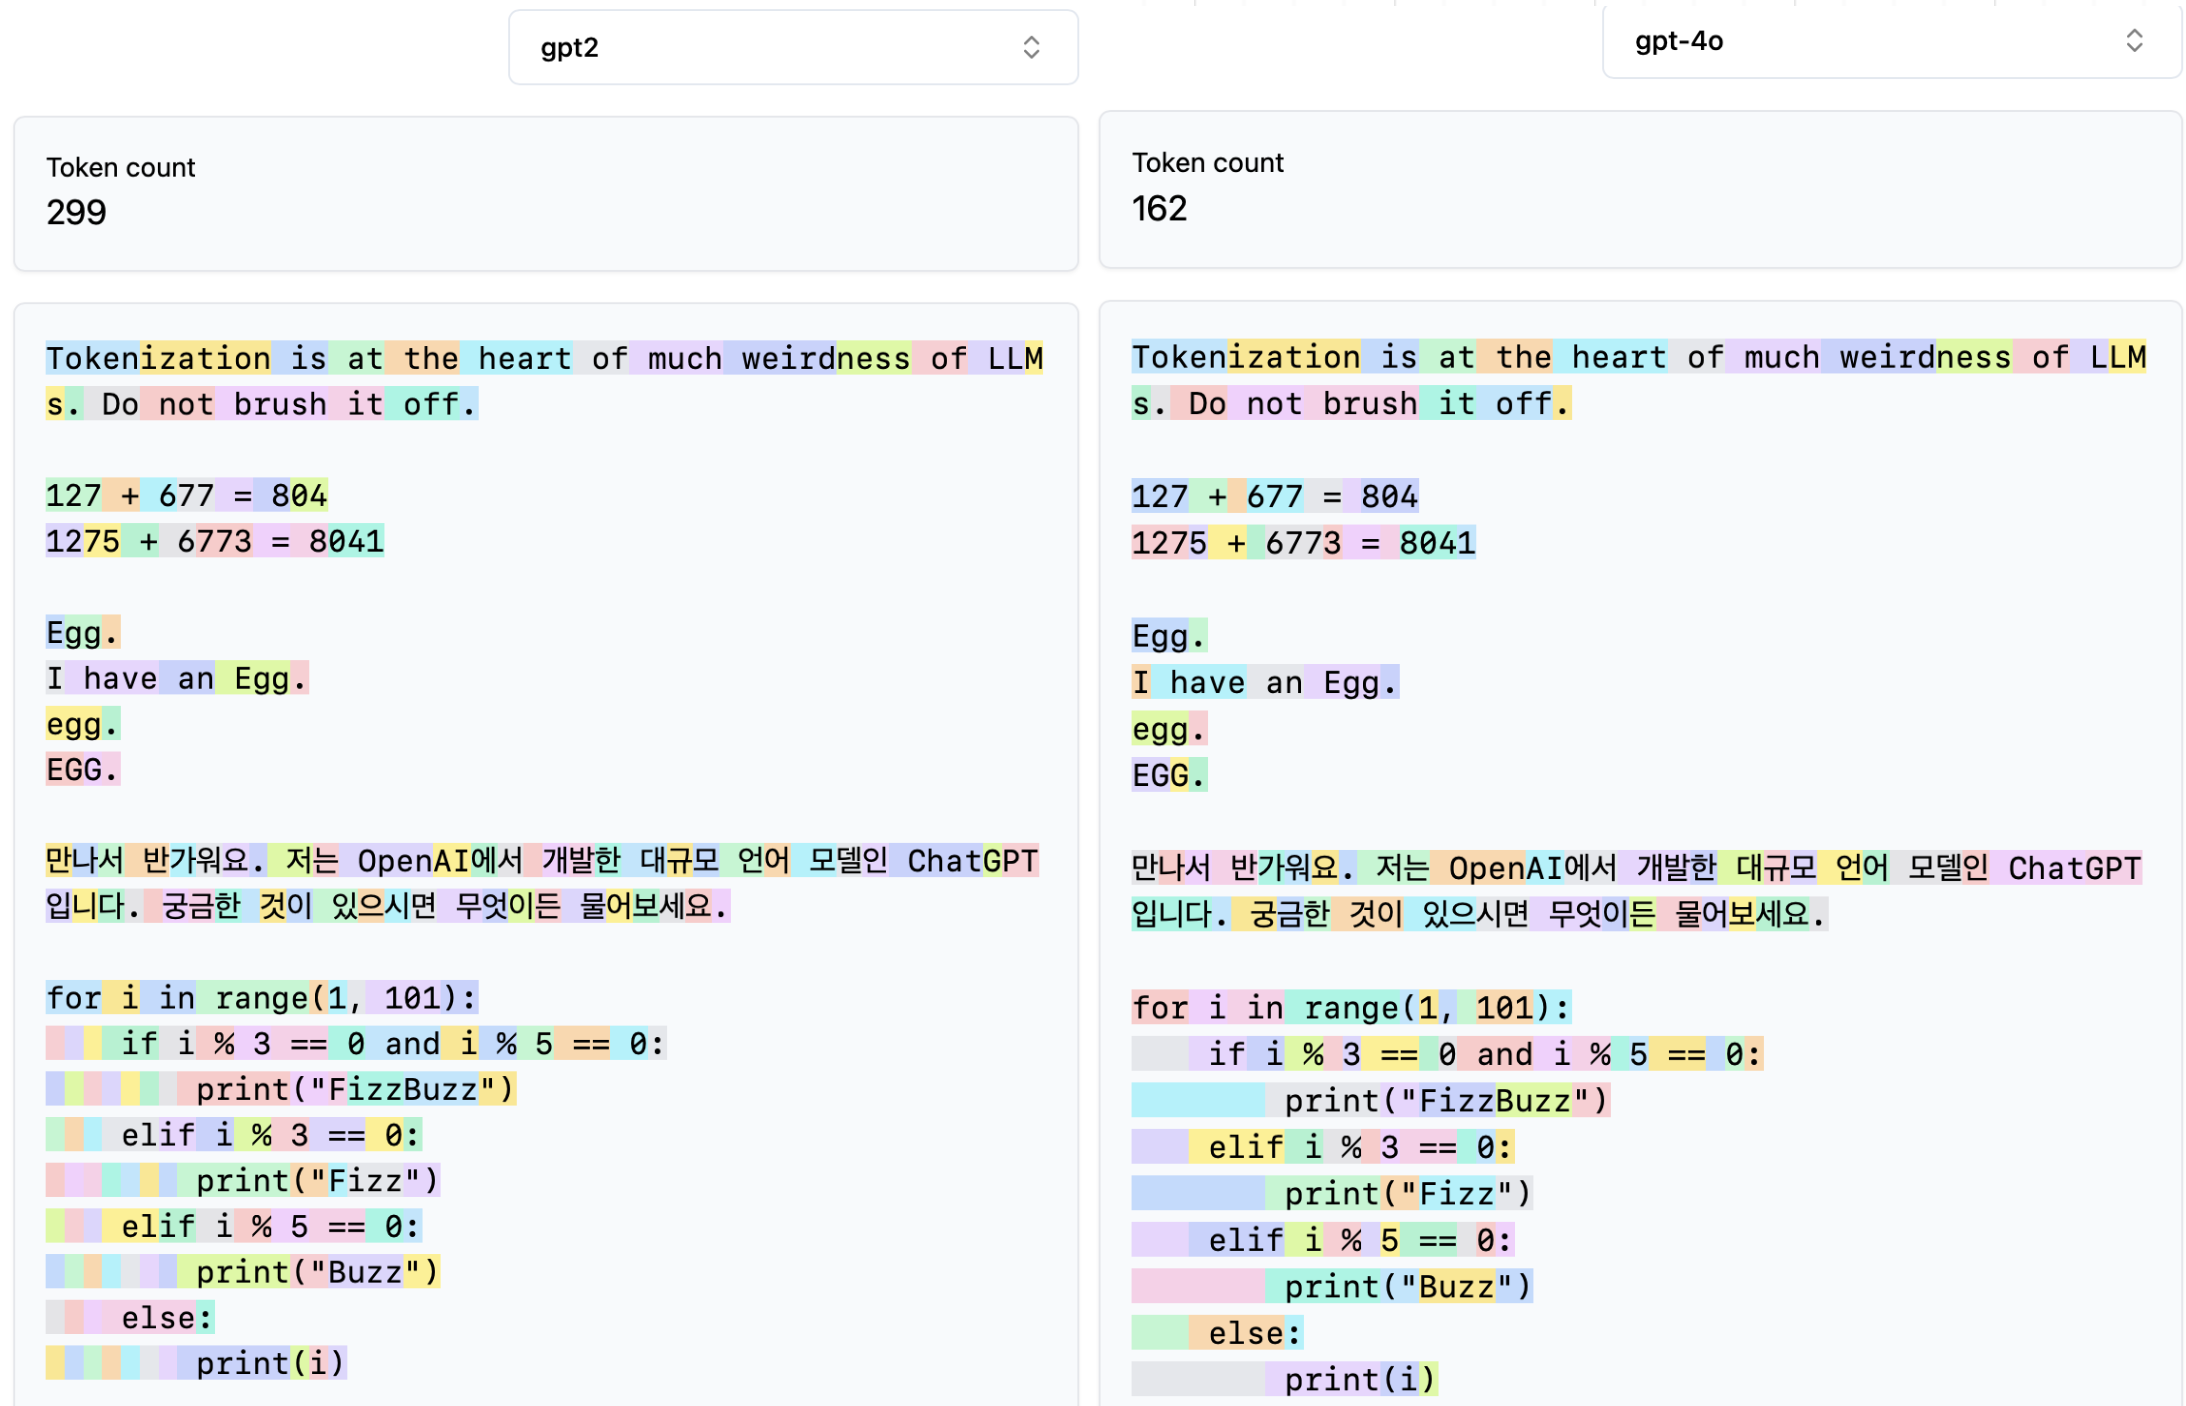

In [18]:
import IPython.display

# notice how bad te spaces are in GPT-2
# responsible for a lot of the improvement in coding
#
# note: this is likely why the maze solving did tokenization
# note: this likely means for tinystories want separate tokenizer
IPython.display.Image('images/example_gpt2_tokenizer_vs_gpt4_tokenizer.png', width=800, height=800)

In [19]:
# we have some arbitrary string
example_string = "你好 😊 I am a string :)"

In [22]:
# we want the code point
# - why can't we just use these integers?
# - the vocabulary would be massive (150,000+ codepoints for unicode)
# - more worryingly, the unicode standard is constantly being updated
#
# - unicode encodings are the actual stable standard for these
#   - UTF-8: maps codepoints to 1-4 bytes
#   - we pretty much always wants utf-8
#    - backwards compatible with ASCII
#    - other ones waste space (among other weird quirks)
#      - ex: utf-16 has 0s for most bytes
#      - ex: even more true for utf-32
#
# - recommended: https://www.reedbeta.com/blog/programmers-intro-to-unicode/
#   - has useful links at the bottom
# 
[ord(c) for c in example_string][:10]

[20320, 22909, 32, 128522, 32, 73, 32, 97, 109, 32]

In [32]:
# to get the actual bytes, we can use `.encode` literally`
print("<char>\t<ord>\t<utf-8 bytes>")
print("---\t---\t---")
for char in example_string:
    print(f"{char}\t{ord(char)}\t{list(char.encode('utf-8'))}")

<char>	<ord>	<utf-8 bytes>
---	---	---
你	20320	[228, 189, 160]
好	22909	[229, 165, 189]
 	32	[32]
😊	128522	[240, 159, 152, 138]
 	32	[32]
I	73	[73]
 	32	[32]
a	97	[97]
m	109	[109]
 	32	[32]
a	97	[97]
 	32	[32]
s	115	[115]
t	116	[116]
r	114	[114]
i	105	[105]
n	110	[110]
g	103	[103]
 	32	[32]
:	58	[58]
)	41	[41]


In [ ]:
# "I would like nothing more than feed the raw bytes into the transformer"
# => tokenization free
#
# [MEGABYTE: Predicting Million-byte Sequences with Multiscale Transformers](https://arxiv.org/abs/2305.07185)
#
# Requires actual changes to model

### Byte Pair Encoding

Example:

`aaabdaaabac`

--> most common is `aa`, replace with byte not used in data (or mark which already used)
```
ZabdZabac
Z=aa
```
--> now most common is `ab`
```
ZYdZYac
Y=ab
Z=aa
```
--> now we're done with this pass since there's no more pairs that occur more than once

--> can continue recursively
```
XdXac
X=ZY
Y=ab
Z=aa
```

In [85]:
import pathlib

# run on more representative file
filepath = pathlib.Path('data/example_text_programmers_introduction_to_unicode.txt')

input_text = filepath.read_text()

In [175]:
from gpt_from_scratch.byte_pair_encoding_tokenizer import BytePairEncodingTokenizer

tokenizer = BytePairEncodingTokenizer.from_input_bytes(
    input_bytes=input_text.encode("utf-8"),
    vocab_size=276, # arbitrary, from Karpathy
)

print("Sanity checking via roundtrip...")
encoded = tokenizer.encode(input_text)
decoded = tokenizer.decode(encoded)

assert decoded == input_text

Constructing 20 merges...
Merging	(101, 32)	[('e', ' ')]	(count: 646)	-> new token: 256
Merging	(105, 110)	[('i', 'n')]	(count: 446)	-> new token: 257
Merging	(115, 32)	[('s', ' ')]	(count: 424)	-> new token: 258
Merging	(116, 104)	[('t', 'h')]	(count: 337)	-> new token: 259
Merging	(101, 114)	[('e', 'r')]	(count: 294)	-> new token: 260
Merging	(99, 111)	[('c', 'o')]	(count: 290)	-> new token: 261
Merging	(116, 32)	[('t', ' ')]	(count: 285)	-> new token: 262
Merging	(226, 128)	[('â', '\x80')]	(count: 247)	-> new token: 263
Merging	(44, 32)	[(',', ' ')]	(count: 243)	-> new token: 264
Merging	(97, 110)	[('a', 'n')]	(count: 229)	-> new token: 265
Merging	(111, 114)	[('o', 'r')]	(count: 214)	-> new token: 266
Merging	(100, 32)	[('d', ' ')]	(count: 213)	-> new token: 267
Merging	(97, 114)	[('a', 'r')]	(count: 181)	-> new token: 268
Merging	(101, 110)	[('e', 'n')]	(count: 174)	-> new token: 269
Merging	(257, 103)	[('ā', 'g')]	(count: 166)	-> new token: 270
Merging	(261, 100)	[('ą', 'd')]	(co

Note, the Tokenizer is a completely separate, independent module from the LLM. 

* It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. 

* It then translates back and forth between raw text and sequences of tokens.

* The LLM later only ever sees the tokens and never directly deals with any text.

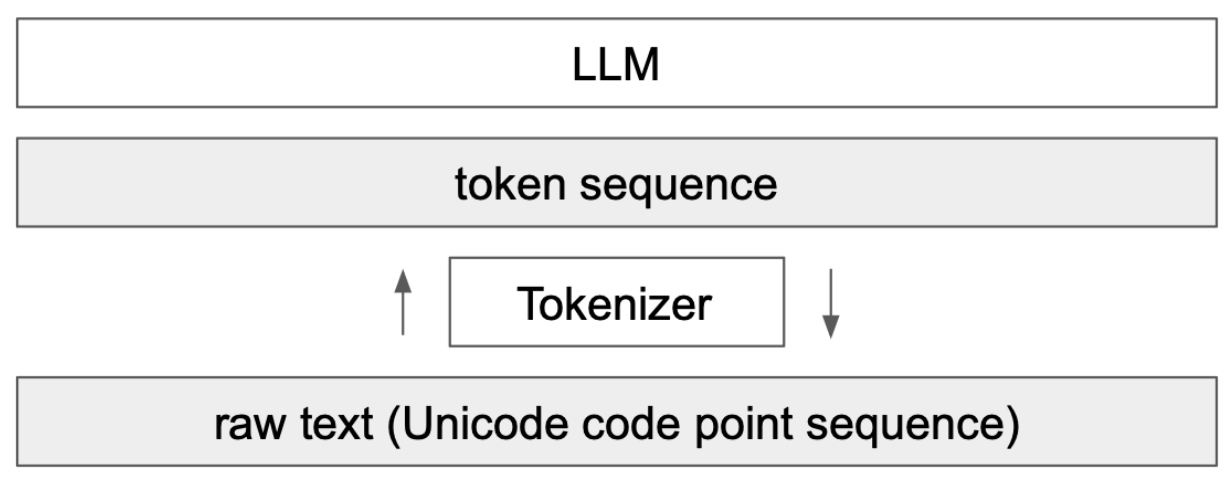

In [176]:
IPython.display.Image('images/llm_tokenizer_diagram.png', width=400, height=400)

In [201]:
from gpt_from_scratch.tokenizer_utils import show_token_mapping

show_token_mapping(tokenizer, 'Showing 你好 😊 I am a string :)')

Input:		Showing 你好 😊 I am a string :)
Tokenized:	Showing ������ ���� I am a string :)
Token ID | Token Bytes | Token String
---------+-------------+--------------
      83 | 53 | 'S'
          Showing 你好 😊 I am a string :)
          U+0053 LATIN CAPITAL LETTER S (1 bytes: 53)
     104 | 68 | 'h'
          Showing 你好 😊 I am a string :)
          U+0068 LATIN SMALL LETTER H (1 bytes: 68)
     111 | 6F | 'o'
          Showing 你好 😊 I am a string :)
          U+006F LATIN SMALL LETTER O (1 bytes: 6F)
     119 | 77 | 'w'
          Showing 你好 😊 I am a string :)
          U+0077 LATIN SMALL LETTER W (1 bytes: 77)
     270 | 69 6E 67 | 'ing'
          Showing 你好 😊 I am a string :)
          U+0069 LATIN SMALL LETTER I (1 bytes: 69)
          U+006E LATIN SMALL LETTER N (1 bytes: 6E)
          U+0067 LATIN SMALL LETTER G (1 bytes: 67)
      32 | 20 | ' '
          Showing 你好 😊 I am a string :)
          U+0020 SPACE (1 bytes: 20)
     228 | E4 | '�'
          Showing 你好 😊 I am a string :)
      

In [119]:
print(tokenizer.decode(tokenizer.encode("hello world")))

Merging	(111, 114)	[('o', 'r')]	(count: 1)	-> new token: 266
hello world


In [120]:

encoded = tokenizer.encode("你好 😊 I am a string :)")

encoded

Merging	(105, 110)	[('i', 'n')]	(count: 1)	-> new token: 257
Merging	(257, 103)	[('ā', 'g')]	(count: 1)	-> new token: 270


[228,
 189,
 160,
 229,
 165,
 189,
 32,
 240,
 159,
 152,
 138,
 32,
 73,
 32,
 97,
 109,
 32,
 97,
 32,
 115,
 116,
 114,
 270,
 32,
 58,
 41]

In [121]:
decoded = tokenizer.decode(encoded)

print(decoded)

你好 😊 I am a string :)


In [122]:
valtext = "Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes thousands of emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters."
valtext2 = tokenizer.decode(tokenizer.encode(valtext))
print(valtext2 == valtext)

Merging	(101, 32)	[('e', ' ')]	(count: 16)	-> new token: 256
Merging	(105, 110)	[('i', 'n')]	(count: 8)	-> new token: 257
Merging	(115, 32)	[('s', ' ')]	(count: 6)	-> new token: 258
Merging	(116, 104)	[('t', 'h')]	(count: 12)	-> new token: 259
Merging	(101, 114)	[('e', 'r')]	(count: 6)	-> new token: 260
Merging	(99, 111)	[('c', 'o')]	(count: 8)	-> new token: 261
Merging	(116, 32)	[('t', ' ')]	(count: 4)	-> new token: 262
Merging	(44, 32)	[(',', ' ')]	(count: 6)	-> new token: 264
Merging	(97, 110)	[('a', 'n')]	(count: 9)	-> new token: 265
Merging	(111, 114)	[('o', 'r')]	(count: 4)	-> new token: 266
Merging	(100, 32)	[('d', ' ')]	(count: 8)	-> new token: 267
Merging	(97, 114)	[('a', 'r')]	(count: 10)	-> new token: 268
Merging	(101, 110)	[('e', 'n')]	(count: 4)	-> new token: 269
Merging	(257, 103)	[('ā', 'g')]	(count: 3)	-> new token: 270
Merging	(261, 100)	[('ą', 'd')]	(count: 5)	-> new token: 271
Merging	(121, 32)	[('y', ' ')]	(count: 4)	-> new token: 272
Merging	(46, 32)	[('.', ' ')]	(